In [86]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm
from pyfinance.ols import PandasRollingOLS

In [2]:
df1=pd.read_excel("财政部-中国国债收益率曲线历史数据2016年01月01日—2016年12月30日.xlsx")
df2=pd.read_excel("17年.xlsx")
df3=pd.read_excel("18年.xlsx")
df4=pd.read_excel("19年.xlsx")
df5=pd.read_excel("20年.xlsx")
df6=pd.read_excel("21年.xlsx")
df7=pd.read_excel("21年.2.xlsx")
df8=pd.read_excel("22年.xlsx")
df=pd.concat([df1,df2,df3,df4,df5,df6,df7,df8]).reset_index().drop("index",1).sort_values("日期")
df["无风险利率"]=(df["5年"]+2.65)/2

D:\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [3]:
CSI300=pd.read_csv("../Shanghai Shenzhen CSI 300 Historical Data (1).csv")
SSEC=pd.read_csv("../Shanghai Composite Historical Data (2).csv")

In [4]:
CSI300["日期"]=CSI300["Date"].astype('datetime64[D]')
SSEC["日期"]=SSEC["Date"].astype('datetime64[D]')
df["日期"]=df["日期"].astype('datetime64[D]')
CSI300["Price"]=CSI300["Price"].str.replace(",","")
CSI300["Price"]=CSI300["Price"].astype(float)
CSI300["Change"]=CSI300["Change %"].str.replace("%","").astype(float)
CSI=CSI300[["日期","Price","Change"]].sort_values("日期")

In [5]:
SSEC["Price"]=SSEC["Price"].str.replace(",","").astype(float)
SSEC["Change"]=SSEC["Change %"].str.replace("%","").astype(float)
ssec=SSEC[["日期","Price","Change"]].sort_values("日期")

In [6]:
CSI=CSI.rename(columns={"Price":"CSI_pri","Change":"CSI_ch"})

In [7]:
ssec=ssec.rename(columns={"Price":"ssec_pri","Change":"ssec_ch"})

In [8]:
indexes=pd.concat([CSI.set_index("日期"),ssec.set_index("日期")],axis=1)
indexes["组合大盘指数"]=(indexes["CSI_pri"]*2+indexes["ssec_pri"]*4)/6
#无风险利率的计算规则：中国银行五年期定期存款利率+5年期国债取平均
norisk=df[["日期","无风险利率"]]
rm_rf=pd.concat([df.set_index("日期")[["无风险利率"]],indexes[["组合大盘指数"]]],axis=1)

In [9]:
#上下两个值的平均值进行填充
rm_rf=rm_rf.fillna(rm_rf.interpolate())
#在此详细介绍下interpolate函数的参数：'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'spline', 'barycentric', 'polynomial'

In [10]:
rm_rf["Rf"]=rm_rf["无风险利率"]/360

In [11]:
rm_rf["Rm"]=rm_rf["组合大盘指数"].pct_change(1)*100

In [12]:
#做一阶滞后
rm_rfL1=rm_rf.shift(1).dropna()

In [13]:
cz1=pd.read_excel("C:/Users/Administrator/Desktop/fintech final project/stock_chosen/成长/002415.SZ.xlsx")
cz2=pd.read_excel("C:/Users/Administrator/Desktop/fintech final project/stock_chosen/成长/002475.SZ.xlsx")
cz3=pd.read_excel("C:/Users/Administrator/Desktop/fintech final project/stock_chosen/成长/601012.SH.xlsx")
s002415=cz1[["日期","收盘价(元)","涨跌幅(%)"]].drop_duplicates("日期").set_index("日期").rename(columns={"收盘价(元)":"002415_price","涨跌幅(%)":"002415_r"})
s002475=cz2[["日期","收盘价(元)","涨跌幅(%)"]].drop_duplicates("日期").set_index("日期").rename(columns={"收盘价(元)":"002475_price","涨跌幅(%)":"002475_r"})
s601012=cz3[["日期","收盘价(元)","涨跌幅(%)"]].drop_duplicates("日期").set_index("日期").rename(columns={"收盘价(元)":"601012_price","涨跌幅(%)":"601012_r"})
cz_all=pd.concat([s002415,s002475,s601012],axis=1).dropna()

In [14]:
wd1=pd.read_excel("C:/Users/Administrator/Desktop/fintech final project/stock_chosen/稳定/600009.SH.xlsx")
wd2=pd.read_excel("C:/Users/Administrator/Desktop/fintech final project/stock_chosen/稳定/601390.SH.xlsx")
wd3=pd.read_excel("C:/Users/Administrator/Desktop/fintech final project/stock_chosen/稳定/601668.SH.xlsx")
s600009=wd1[["日期","收盘价(元)","涨跌幅(%)"]].drop_duplicates("日期").set_index("日期").rename(columns={"收盘价(元)":"600009_price","涨跌幅(%)":"600009_r"})
s601390=wd2[["日期","收盘价(元)","涨跌幅(%)"]].drop_duplicates("日期").set_index("日期").rename(columns={"收盘价(元)":"601390_price","涨跌幅(%)":"601390_r"})
s601668=wd3[["日期","收盘价(元)","涨跌幅(%)"]].drop_duplicates("日期").set_index("日期").rename(columns={"收盘价(元)":"601668_price","涨跌幅(%)":"601668_r"})
wd_all=pd.concat([s600009,s601390,s601668],axis=1).dropna()

### Use 1-term lag Rm & Rf to predict future return
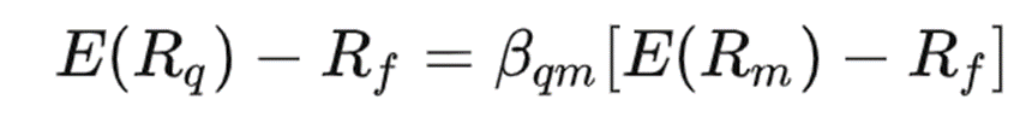

In [216]:
#长期预测
import warnings
def longterm(s002415):
    warnings.filterwarnings('ignore')
    tore=pd.concat([s002415,rm_rfL1],axis=1).dropna()
    tore["risk_flow"]=tore.iloc[:,1]-tore["Rf"]
    tore["mkt_flow"]=tore["Rm"]-tore["Rf"]
    #训练集
    train=tore.iloc[:1459,:]
    #预测集
    pred=tore.iloc[1459:,:]
    X=train["mkt_flow"]
    Y=train["risk_flow"]
    X2 = sm.add_constant(X)
    est = sm.OLS(Y,X2).fit()
    pred["risk_flow预测值"]=est.predict(sm.add_constant(pred["mkt_flow"]))
    u=((pred["risk_flow"]-pred["risk_flow预测值"])**2).sum()
    v=((pred["risk_flow"]-pred["risk_flow"].mean())**2).sum()
    r2_score=1-u/v
    pred["是否买入"]=pred["risk_flow预测值"].apply(lambda x:1 if x>0 else 0)
    pred["实际是否涨"]=pred["risk_flow"].apply(lambda x:1 if x>0 else 0)
    Accuracy=len(pred[(pred["是否买入"]==pred["实际是否涨"])==True])/len(pred)
    return r2_score,Accuracy

In [197]:
#长期预测(无差分)
import warnings
def longterm_2(s002415):
    warnings.filterwarnings('ignore')
    tore=pd.concat([s002415,rm_rf],axis=1).dropna()
    tore["risk_flow"]=tore.iloc[:,1]-tore["Rf"]
    tore["mkt_flow"]=tore["Rm"]-tore["Rf"]
    #训练集
    train=tore.iloc[:1459,:]
    #预测集
    pred=tore.iloc[1459:,:]
    X=train["mkt_flow"]
    Y=train["risk_flow"]
    X2 = sm.add_constant(X)
    est = sm.OLS(Y,X2).fit()
    pred["risk_flow预测值"]=est.predict(sm.add_constant(pred["mkt_flow"]))
    u=((pred["risk_flow"]-pred["risk_flow预测值"])**2).sum()
    v=((pred["risk_flow"]-pred["risk_flow"].mean())**2).sum()
    r2_score=1-u/v
    pred["是否买入"]=pred["risk_flow预测值"].apply(lambda x:1 if x>0 else 0)
    pred["实际是否涨"]=pred["risk_flow"].apply(lambda x:1 if x>0 else 0)
    Accuracy=len(pred[(pred["是否买入"]==pred["实际是否涨"])==True])/len(pred)
    return r2_score,Accuracy

In [105]:
#滚动回归-60天
import warnings
def gundong(s002415):
    tore=pd.concat([s002415,rm_rfL1],axis=1).dropna()
    tore["risk_flow"]=tore.iloc[:,1]-tore["Rf"]
    tore["mkt_flow"]=tore["Rm"]-tore["Rf"]
    X=tore["mkt_flow"]
    Y=tore["risk_flow"]
    results = PandasRollingOLS(X, Y, 60)  # window 是滚动回归的自变量个数
    tore["peri_beta"]=results.beta
    tore["peri_alpha"]=results.alpha
    tore["risk_flow预测值"]=tore["peri_beta"]*tore["mkt_flow"]-tore["peri_alpha"]+tore["Rf"]

    to_pred=tore.iloc[1459:,:]
    u=((to_pred["risk_flow"]-to_pred["risk_flow预测值"])**2).sum()
    v=((to_pred["risk_flow"]-to_pred["risk_flow"].mean())**2).sum()
    r2_score=1-u/v
    to_pred["是否买入"]=to_pred["risk_flow预测值"].apply(lambda x:1 if x>0 else 0)
    to_pred["实际是否涨"]=to_pred["risk_flow"].apply(lambda x:1 if x>0 else 0)
    Accuracy=len(to_pred[(to_pred["是否买入"]==to_pred["实际是否涨"])==True])/len(to_pred)
    return r2_score,Accuracy

In [107]:
#滚动回归-180天
import warnings
def gundong(s002415):
    tore=pd.concat([s002415,rm_rfL1],axis=1).dropna()
    tore["risk_flow"]=tore.iloc[:,1]-tore["Rf"]
    tore["mkt_flow"]=tore["Rm"]-tore["Rf"]
    X=tore["mkt_flow"]
    Y=tore["risk_flow"]
    results = PandasRollingOLS(X, Y, 180)  # window 是滚动回归的自变量个数
    tore["peri_beta"]=results.beta
    tore["peri_alpha"]=results.alpha
    tore["risk_flow预测值"]=tore["peri_beta"]*tore["mkt_flow"]-tore["peri_alpha"]+tore["Rf"]

    to_pred=tore.iloc[1459:,:]
    u=((to_pred["risk_flow"]-to_pred["risk_flow预测值"])**2).sum()
    v=((to_pred["risk_flow"]-to_pred["risk_flow"].mean())**2).sum()
    r2_score=1-u/v
    to_pred["是否买入"]=to_pred["risk_flow预测值"].apply(lambda x:1 if x>0 else 0)
    to_pred["实际是否涨"]=to_pred["risk_flow"].apply(lambda x:1 if x>0 else 0)
    Accuracy=len(to_pred[(to_pred["是否买入"]==to_pred["实际是否涨"])==True])/len(to_pred)
    return r2_score,Accuracy

In [92]:
warnings.filterwarnings('ignore')
tore=pd.concat([s002415,rm_rfL1],axis=1).dropna()
tore["risk_flow"]=tore.iloc[:,1]-tore["Rf"]
tore["mkt_flow"]=tore["Rm"]-tore["Rf"]
X=tore["mkt_flow"]
Y=tore["risk_flow"]
results = PandasRollingOLS(X, Y, 60)

tore["risk_flow预测值"]=est.toreict(sm.add_constant(tore["mkt_flow"]))
u=((tore["risk_flow"]-tore["risk_flow预测值"])**2).sum()
v=((tore["risk_flow"]-tore["risk_flow"].mean())**2).sum()
r2_score=1-u/v
tore["是否买入"]=tore["risk_flow预测值"].apply(lambda x:1 if x>0 else 0)
tore["实际是否涨"]=tore["risk_flow"].apply(lambda x:1 if x>0 else 0)
Accuracy=len(tore[(tore["是否买入"]==tore["实际是否涨"])==True])/len(tore)
return r2_score,Accuracy

### Use 1-term lag Rm & Rf to predict future return
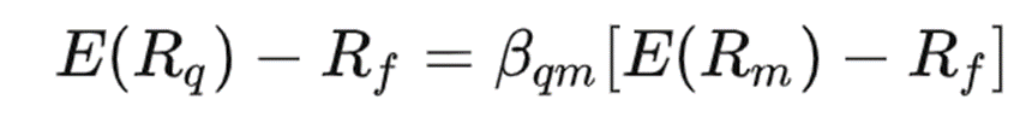

In [100]:
results = PandasRollingOLS(X, Y, 60)  # window 是滚动回归的自变量个数
tore["peri_beta"]=results.beta
tore["peri_alpha"]=results.alpha
tore["risk_flow预测值"]=tore["peri_beta"]*tore["mkt_flow"]-tore["peri_alpha"]+tore["Rf"]

to_pred=tore.iloc[1459:,:]
u=((to_pred["risk_flow"]-to_pred["risk_flow预测值"])**2).sum()
v=((to_pred["risk_flow"]-to_pred["risk_flow"].mean())**2).sum()
r2_score=1-u/v
to_pred["是否买入"]=to_pred["risk_flow预测值"].apply(lambda x:1 if x>0 else 0)
to_pred["实际是否涨"]=to_pred["risk_flow"].apply(lambda x:1 if x>0 else 0)
Accuracy=len(to_pred[(to_pred["是否买入"]==to_pred["实际是否涨"])==True])/len(to_pred)


In [68]:
#(1+(pred["risk_flow预测值"]+pred["Rf"]))*tore.iloc[1458,0]
pred["Er"]=pred["risk_flow预测值"]+pred["Rf"]
pred["Cum_Er"]=round(round(pred["Er"],2).cumprod(axis=0),2)
pred["future_price"]=pred["Cum_Er"]*tore.iloc[1458,0]

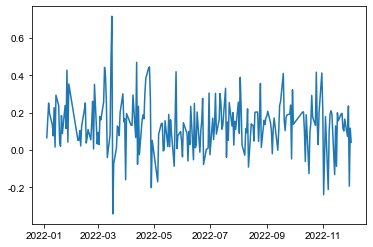

In [70]:
plt.plot(pred["Er"])

In [74]:
tore.iloc[1458,0]

52.32

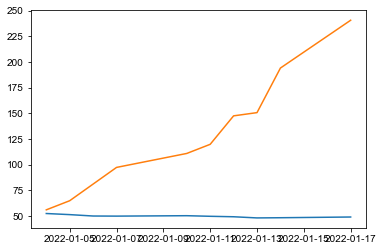

In [84]:
plt.plot(pred.iloc[:10,:]["002415_price"])
plt.plot(pred.iloc[:10,:]["future_price"])

In [28]:
warnings.filterwarnings('ignore')
tore=pd.concat([s002415,rm_rfL1],axis=1).dropna()
tore["risk_flow"]=tore.iloc[:,1]-tore["Rf"]
tore["mkt_flow"]=tore["Rm"]-tore["Rf"]
#训练集
train=tore.iloc[:1459,:]
#预测集
pred=tore.iloc[1459:,:]
X=train["mkt_flow"]
Y=train["risk_flow"]
X2 = sm.add_constant(X)
est = sm.OLS(Y,X2).fit()
pred["risk_flow预测值"]=est.predict(sm.add_constant(pred["mkt_flow"]))
u=((pred["risk_flow"]-pred["risk_flow预测值"])**2).sum()
v=((pred["risk_flow"]-pred["risk_flow"].mean())**2).sum()
r2_score=1-u/v
pred["是否买入"]=pred["risk_flow预测值"].apply(lambda x:1 if x>0 else 0)
pred["实际是否涨"]=pred["risk_flow"].apply(lambda x:1 if x>0 else 0)
Accuracy=len(pred[(pred["是否买入"]==pred["实际是否涨"])==True])/len(pred)

,002415_price,002415_r,无风险利率,组合大盘指数,Rf,Rm,risk_flow,mkt_flow,risk_flow预测值,是否买入,实际是否涨
日期,,,,,,,,,,,
2022-01-04,52.41,0.1720,2.630,4073.310000,0.007306,0.493754,0.164694,0.486449,0.058649,1,1
2022-01-05,51.33,-2.0607,2.630,4060.810000,0.007306,-0.306876,-2.068006,-0.314181,0.156774,1,0
2022-01-06,49.97,-2.6495,2.645,4019.493333,0.007347,-1.017449,-2.656847,-1.024796,0.243867,1,0
2022-01-07,49.87,-0.2001,2.655,3996.796667,0.007375,-0.564665,-0.207475,-0.572040,0.188377,1,0
2022-01-10,50.28,0.8221,2.650,3993.816667,0.007361,-0.074560,0.814739,-0.081921,0.128308,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2022-11-28,30.37,-1.7152,2.630,3326.386667,0.007306,0.440142,-1.722506,0.432836,0.065219,1,0
2022-11-29,31.64,4.1818,2.650,3296.780000,0.007361,-0.890055,4.174439,-0.897416,0.228255,1,1
2022-11-30,31.51,-0.4109,2.675,3382.640000,0.007431,2.604359,-0.418331,2.596929,-0.200012,0,0


In [ ]:
pred["risk_flow预测值"]

In [16]:
longterm(s002415)

(-0.029732376741647304, 0.45495495495495497)

In [17]:
longterm(s002475)

(-0.010293494811097537, 0.42792792792792794)

In [18]:
longterm(s601012)

(-0.01213976700103081, 0.46396396396396394)

In [19]:
longterm(s600009)

(-0.0028805310018251706, 0.46846846846846846)

In [20]:
longterm(s601390)

(-0.0003466785631625058, 0.527027027027027)

In [21]:
longterm(s601668)

(-0.002673897859305052, 0.5336322869955157)

In [22]:
data=(longterm(s002415),longterm(s002475),longterm(s601012),longterm(s600009),longterm(s601390),longterm(s601668))
list(data)

[(-0.029732376741647304, 0.45495495495495497),
 (-0.010293494811097537, 0.42792792792792794),
 (-0.01213976700103081, 0.46396396396396394),
 (-0.0028805310018251706, 0.46846846846846846),
 (-0.0003466785631625058, 0.527027027027027),
 (-0.002673897859305052, 0.5336322869955157)]

In [23]:
pd.DataFrame(list(data),columns=["R2-score","Accuracy"],index=["002415","002475","601012","600009","601390","601668"])

,R2-score,Accuracy
002415,-0.029732,0.454955
002475,-0.010293,0.427928
601012,-0.012140,0.463964
600009,-0.002881,0.468468
601390,-0.000347,0.527027
601668,-0.002674,0.533632


In [24]:
#长期预测
def shorterm(s002415):
    tore=pd.concat([s002415,rm_rfL1],axis=1).dropna()
    tore["risk_flow"]=tore.iloc[:,1]-tore["Rf"]
    tore["mkt_flow"]=tore["Rm"]-tore["Rf"]
    #训练集
    train=tore.iloc[:1459,:]
    #预测集
    pred=tore.iloc[1459:,:]
    X=train["mkt_flow"]
    Y=train["risk_flow"]
    X2 = sm.add_constant(X)
    est = sm.OLS(Y,X2).fit()
    pred["risk_flow预测值"]=est.predict(sm.add_constant(pred["mkt_flow"]))
    predi=pred.iloc[:7,:]
    u=((predi["risk_flow"]-predi["risk_flow预测值"])**2).sum()
    v=((predi["risk_flow"]-predi["risk_flow"].mean())**2).sum()
    r2_score=1-u/v
    pred["是否买入"]=pred["risk_flow预测值"].apply(lambda x:1 if x>0 else 0)
    pred["实际是否涨"]=pred["risk_flow"].apply(lambda x:1 if x>0 else 0)
    Accuracy=len(pred[(pred["是否买入"]==pred["实际是否涨"])==True])/len(pred)
    return r2_score,Accuracy

In [25]:
data=(shorterm(s002415),shorterm(s002475),shorterm(s601012),shorterm(s600009),shorterm(s601390),shorterm(s601668))
pd.DataFrame(list(data),columns=["R2-score","Accuracy"],index=["002415","002475","601012","600009","601390","601668"])

,R2-score,Accuracy
002415,-0.853469,0.454955
002475,-0.057874,0.427928
601012,-0.418573,0.463964
600009,-0.352959,0.468468
601390,-0.177817,0.527027
601668,-0.195425,0.533632


In [106]:
data=(gundong(s002415),gundong(s002475),gundong(s601012),gundong(s600009),gundong(s601390),gundong(s601668))
pd.DataFrame(list(data),columns=["R2-score","Accuracy"],index=["002415","002475","601012","600009","601390","601668"])

,R2-score,Accuracy
002415,-0.006452,0.545045
002475,-0.009949,0.432432
601012,0.005066,0.450450
600009,0.003861,0.504505
601390,0.009270,0.545045
601668,0.006065,0.547085


In [108]:
data=(gundong(s002415),gundong(s002475),gundong(s601012),gundong(s600009),gundong(s601390),gundong(s601668))
pd.DataFrame(list(data),columns=["R2-score","Accuracy"],index=["002415","002475","601012","600009","601390","601668"])

,R2-score,Accuracy
002415,-0.007640,0.509009
002475,-0.004515,0.405405
601012,0.000620,0.477477
600009,0.004068,0.481982
601390,0.003411,0.486486
601668,0.003446,0.511211


In [27]:
# plt.rcParams['font.sans-serif'] = ['Arial']
# plt.rcParams['axes.unicode_minus'] = False

# rkreal = pred["risk_flow"]
# predct = pred["risk_flow预测值"]
# #根据ticker的功能改变第一个为初始的数据，第二个则为距离
# ticker_spacing = 70

# #创建画布
# fig, ax = plt.subplots(figsize = (20, 10))
# ax.plot(rkreal,c='red', label="real risk_flow")
# ax.plot(predct, c='green',  label="risk_flow pred")
# ax.xaxis.set_major_locator(ticker.MultipleLocator(ticker_spacing))

# plt.legend(loc='best')

# plt.grid(True, linestyle='--', alpha=0.5)
# plt.xlabel("Date", fontdict={'size': 16})
# plt.ylabel("Return", fontdict={'size': 16})
# plt.title("Hkvision Prediction", fontdict={'size': 20})
# plt.show()

In [120]:
def gundong(s002415,n):
    tore=pd.concat([s002415,rm_rfL1],axis=1).dropna()
    tore["risk_flow"]=tore.iloc[:,1]-tore["Rf"]
    tore["mkt_flow"]=tore["Rm"]-tore["Rf"]
    X=tore["mkt_flow"]
    Y=tore["risk_flow"]
    results = PandasRollingOLS(X, Y, n)  # window 是滚动回归的自变量个数
    tore["peri_beta"]=results.beta
    tore["peri_alpha"]=results.alpha
    tore["risk_flow预测值"]=tore["peri_beta"]*tore["mkt_flow"]-tore["peri_alpha"]+tore["Rf"]

    to_pred=tore.iloc[1459:,:]
    u=((to_pred["risk_flow"]-to_pred["risk_flow预测值"])**2).sum()
    v=((to_pred["risk_flow"]-to_pred["risk_flow"].mean())**2).sum()
    r2_score=1-u/v
    to_pred["是否买入"]=to_pred["risk_flow预测值"].apply(lambda x:1 if x>0 else 0)
    to_pred["实际是否涨"]=to_pred["risk_flow"].apply(lambda x:1 if x>0 else 0)
    Accuracy=len(to_pred[(to_pred["是否买入"]==to_pred["实际是否涨"])==True])/len(to_pred)
    
    return r2_score,Accuracy,n

In [168]:
def choose_n(s002415):
    list1=[]
    for n in range(10,200,10):
        list1.append(gundong(s002415,n))
    model_choose=pd.DataFrame(list1,columns=["R2-score","Accuracy","n"],index=np.arange(10,200,10))
    bestn=model_choose[model_choose["R2-score"]==model_choose["R2-score"].max()].iloc[0,2]
    return bestn

In [169]:
def best_gundong(s002415):
    tore=pd.concat([s002415,rm_rfL1],axis=1).dropna()
    tore["risk_flow"]=tore.iloc[:,1]-tore["Rf"]
    tore["mkt_flow"]=tore["Rm"]-tore["Rf"]
    X=tore["mkt_flow"]
    Y=tore["risk_flow"]
    results = PandasRollingOLS(X, Y, choose_n(s002415))  # window 是滚动回归的自变量个数
    tore["peri_beta"]=results.beta
    tore["peri_alpha"]=results.alpha
    tore["risk_flow预测值"]=tore["peri_beta"]*tore["mkt_flow"]-tore["peri_alpha"]+tore["Rf"]

    to_pred=tore.iloc[1459:,:]
    u=((to_pred["risk_flow"]-to_pred["risk_flow预测值"])**2).sum()
    v=((to_pred["risk_flow"]-to_pred["risk_flow"].mean())**2).sum()
    r2_score=1-u/v
    to_pred["是否买入"]=to_pred["risk_flow预测值"].apply(lambda x:1 if x>0 else 0)
    to_pred["实际是否涨"]=to_pred["risk_flow"].apply(lambda x:1 if x>0 else 0)
    Accuracy=len(to_pred[(to_pred["是否买入"]==to_pred["实际是否涨"])==True])/len(to_pred)
    
    return r2_score,Accuracy,bestn

In [172]:
data=(best_gundong(s002415),best_gundong(s002475),best_gundong(s601012),best_gundong(s600009),best_gundong(s601390),best_gundong(s601668))
pd.DataFrame(data,columns=["R2-score","Accuracy","best_n"],index=["002415","002475","601012","600009","601390","601668"])

,R2-score,Accuracy,best_n
002415,0.007312,0.576577,10
002475,-0.001150,0.463964,10
601012,0.020006,0.513514,10
600009,0.042911,0.540541,10
601390,0.022301,0.603604,10
601668,0.008107,0.538117,10


In [174]:
def gundong_table(s002415):
    tore=pd.concat([s002415,rm_rfL1],axis=1).dropna()
    tore["risk_flow"]=tore.iloc[:,1]-tore["Rf"]
    tore["mkt_flow"]=tore["Rm"]-tore["Rf"]
    X=tore["mkt_flow"]
    Y=tore["risk_flow"]
    results = PandasRollingOLS(X, Y, choose_n(s002415))  # window 是滚动回归的自变量个数
    tore["peri_beta"]=results.beta
    tore["peri_alpha"]=results.alpha
    tore["risk_flow预测值"]=tore["peri_beta"]*tore["mkt_flow"]-tore["peri_alpha"]+tore["Rf"]

    to_pred=tore.iloc[1459:,:]
    u=((to_pred["risk_flow"]-to_pred["risk_flow预测值"])**2).sum()
    v=((to_pred["risk_flow"]-to_pred["risk_flow"].mean())**2).sum()
    r2_score=1-u/v
    to_pred["是否买入"]=to_pred["risk_flow预测值"].apply(lambda x:1 if x>0 else 0)
    to_pred["实际是否涨"]=to_pred["risk_flow"].apply(lambda x:1 if x>0 else 0)
    Accuracy=len(to_pred[(to_pred["是否买入"]==to_pred["实际是否涨"])==True])/len(to_pred)
    
    return to_pred

In [176]:
s002415_pred=gundong_table(s002415)

In [192]:
s002415_pred["Er"]=(s002415_pred["risk_flow预测值"]+s002415_pred["Rf"])+1
s002415_pred["Cum_Er"]=round(round(s002415_pred["Er"],2).cumprod(axis=0),2)
s002415_pred["future_price"]=s002415_pred["Cum_Er"]*s002415.iloc[1460,0]

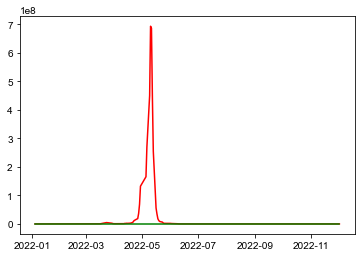

In [195]:
plt.plot(s002415_pred["future_price"],c="red")
plt.plot(s002415_pred["002415_price"],c="green")

In [200]:
#长期预测(无差分)
import warnings
def longterm_2_table(s002415):
    warnings.filterwarnings('ignore')
    tore=pd.concat([s002415,rm_rf],axis=1).dropna()
    tore["risk_flow"]=tore.iloc[:,1]-tore["Rf"]
    tore["mkt_flow"]=tore["Rm"]-tore["Rf"]
    #训练集
    train=tore.iloc[:1459,:]
    #预测集
    pred=tore.iloc[1459:,:]
    X=train["mkt_flow"]
    Y=train["risk_flow"]
    X2 = sm.add_constant(X)
    est = sm.OLS(Y,X2).fit()
    pred["risk_flow预测值"]=est.predict(sm.add_constant(pred["mkt_flow"]))
    u=((pred["risk_flow"]-pred["risk_flow预测值"])**2).sum()
    v=((pred["risk_flow"]-pred["risk_flow"].mean())**2).sum()
    r2_score=1-u/v
    pred["是否买入"]=pred["risk_flow预测值"].apply(lambda x:1 if x>0 else 0)
    pred["实际是否涨"]=pred["risk_flow"].apply(lambda x:1 if x>0 else 0)
    Accuracy=len(pred[(pred["是否买入"]==pred["实际是否涨"])==True])/len(pred)
    print(r2_score)
    print(Accuracy)
    return pred

In [202]:
def plot_stock(s002415):
    s002415_pred=longterm_2_table(s002415)
    s002415_pred["Er"]=(s002415_pred["risk_flow预测值"]+s002415_pred["Rf"])+1
    s002415_pred["Cum_Er"]=round(round(s002415_pred["Er"],2).cumprod(axis=0),2)
    s002415_pred["future_price"]=s002415_pred["Cum_Er"]*s002415.iloc[1460,0]
    plt.plot(s002415_pred["future_price"],c="red")
    plt.plot(s002415_pred["002415_price"],c="green")

0.30388630915872705
0.6591928251121076


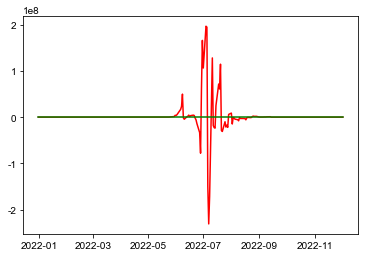

In [205]:
plot_stock(s002415)

In [207]:
data=(longterm_2(s002415),longterm_2(s002475),longterm_2(s601012),longterm_2(s600009),longterm_2(s601390),longterm_2(s601668))
pd.DataFrame(data,columns=["R2-score","Accuracy"],index=["002415","002475","601012","600009","601390","601668"])

,R2-score,Accuracy
002415,0.303886,0.659193
002475,0.284178,0.713004
601012,0.304481,0.704036
600009,0.259479,0.677130
601390,0.163732,0.645740
601668,0.180805,0.602679


## CAPM 最终版

In [211]:
#长期预测
import warnings
def longterm_table(s002415):
    warnings.filterwarnings('ignore')
    tore=pd.concat([s002415,rm_rfL1],axis=1).dropna()
    tore["risk_flow"]=tore.iloc[:,1]-tore["Rf"]
    tore["mkt_flow"]=tore["Rm"]-tore["Rf"]
    #训练集
    train=tore.iloc[:1459,:]
    #预测集
    pred=tore.iloc[1459:,:]
    X=train["mkt_flow"]
    Y=train["risk_flow"]
    X2 = sm.add_constant(X)
    est = sm.OLS(Y,X2).fit()
    pred["risk_flow预测值"]=est.predict(sm.add_constant(pred["mkt_flow"]))
    u=((pred["risk_flow"]-pred["risk_flow预测值"])**2).sum()
    v=((pred["risk_flow"]-pred["risk_flow"].mean())**2).sum()
    r2_score=1-u/v
    pred["是否买入"]=pred["risk_flow预测值"].apply(lambda x:1 if x>0 else 0)
    pred["实际是否涨"]=pred["risk_flow"].apply(lambda x:1 if x>0 else 0)
    Accuracy=len(pred[(pred["是否买入"]==pred["实际是否涨"])==True])/len(pred)
    return pred

In [221]:
def plot_stock(s002415):
    s002415_pred=longterm_table(s002415)
    s002415_pred["Er"]=(s002415_pred["risk_flow预测值"]+s002415_pred["Rf"])+1
    s002415_pred["Cum_Er"]=round(round(s002415_pred["Er"],2).cumprod(axis=0),2)
    s002415_pred["future_price"]=s002415_pred["Cum_Er"]*s002415.iloc[1460,0]
    plt.plot(s002415_pred["future_price"],c="red")
    plt.plot(s002415_pred.iloc[:,0],c="green")

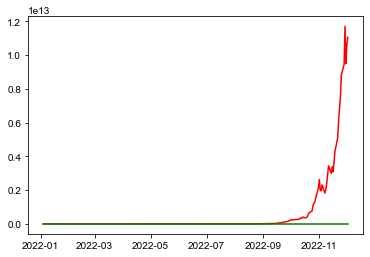

In [213]:
plot_stock(s002415)

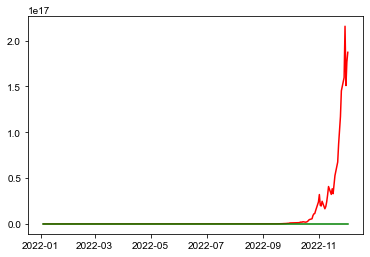

In [222]:
plot_stock(s002475)

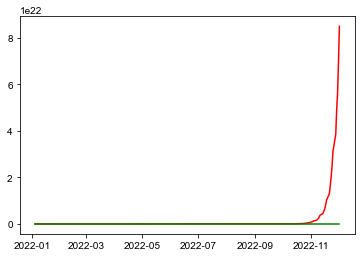

In [223]:
plot_stock(s601012)

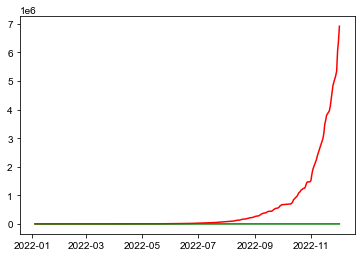

In [225]:
plot_stock(s600009)

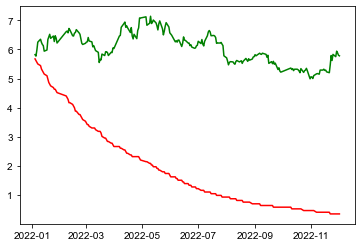

In [226]:
plot_stock(s601390)

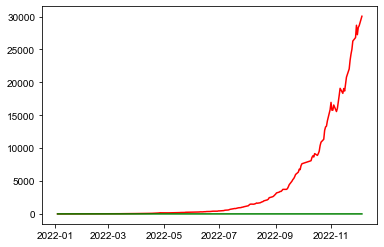

In [227]:
plot_stock(s601668)

In [217]:
data=(longterm(s002415),longterm(s002475),longterm(s601012),longterm(s600009),longterm(s601390),longterm(s601668))
pd.DataFrame(data,columns=["R2-score","Accuracy"],index=["002415","002475","601012","600009","601390","601668"])

,R2-score,Accuracy
002415,-0.029732,0.454955
002475,-0.010293,0.427928
601012,-0.012140,0.463964
600009,-0.002881,0.468468
601390,-0.000347,0.527027
601668,-0.002674,0.533632
